### Lab session: representing a digital surface model with a neural network

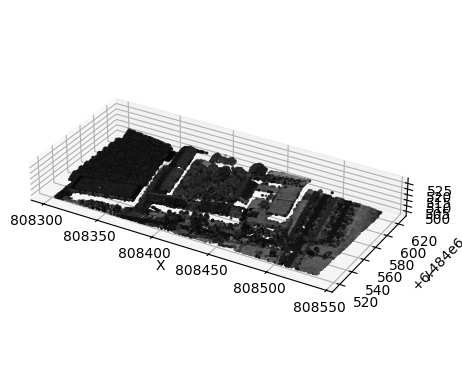

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_loaded = pd.read_csv("lidar_light.csv")
Xsmall = df_loaded["x"].to_numpy()
Ysmall = df_loaded["y"].to_numpy()
Zsmall = df_loaded["z"].to_numpy()
Ismall = df_loaded["I"].to_numpy()


Xsmall_norm = (Xsmall - Xsmall.min()) / (Xsmall.max() - Xsmall.min())
Ysmall_norm = (Ysmall - Ysmall.min()) / (Ysmall.max() - Ysmall.min())
Zsmall_norm = (Zsmall - Zsmall.min()) / (Zsmall.max() - Zsmall.min())
Ismall_norm = (Ismall - Ismall.min()) / (Ismall.max() - Ismall.min())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xsmall, Ysmall, Zsmall, c=(Ismall.astype(np.float64))/np.max(Ismall), marker='o', s=1,cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()

In [13]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader

# F(x, y) = z

# STACKING INPUTS IN (N,2) MATRIX
inputs = np.stack([Xsmall_norm, Ysmall_norm], axis=1)

# SHAPING OUTPUT IN (N, 1)
targets = Zsmall_norm.reshape(-1, 1)
# CONVERTING NUMPY ARRAYS TO TENSOR
i_tensor = torch.tensor(inputs, dtype=torch.float32)
o_tensor = torch.tensor(targets, dtype=torch.float32)

# COMPLETE DATASET
dataset = TensorDataset(i_tensor, o_tensor)

# SPLITTING IN DIFFERENT SIZES
N = len(dataset)
n_train = int(0.7*N)
n_val = int(0.15*N)
n_test = int(0.15*N)

# RANDOM ATTRIBUTION
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(43))

print(f"Train : {len(train_set)}, Val : {len(val_set)}, Test : {len(test_set)}")
print(train_set[2])

Train : 35000, Val : 7500, Test : 7500
(tensor([0.0130, 0.5260]), tensor([0.2575]))


In [14]:
import torch
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu" 

class SinActivation(nn.Module) :
    def forward(self, x):
        return torch.sin(x)
    
class NeuralNetwork(nn.Module) :
    def __init__(self, input_dim, output_dim, width, depth = 3, activation = 'relu') :
        super().__init__()

        self.activation = activation
        self.factivation = nn.ReLU() if (isinstance(activation, str) and activation == 'relu') else SinActivation()

        layers = []

        # INPUT LAYER
        layers.append(nn.Linear(input_dim, width))
        layers.append(self.factivation)

        # HIDDEN LAYERS
        for _ in range(depth - 1) :
            layers.append(nn.Linear(width, width))
            layers.append(self.factivation)

        # OUTPUT LAYER
        layers.append(nn.Linear(width, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x) :
        return self.net(x)

class CustomOptimizer():
    def __init__(self, params, lr) :
        self.params = list(params)
        self.lr = lr
        super().__init__()

    def sgd(self) :
        for p in self.params :
            if p.grad is not None :
                p = torch.sub(p, self.lr * p.grad)
                # p.data -= learning_rate * p.grad.data
                # p.grad.zero_()

    def zeroing_grad(self) :
        for p in self.params :
            if p.grad is not None :
                p.grad.zero_()

In [ ]:
# HYPER PARAMETERS
learning_rate = 1e-3
batch_size = 64
epochs = 5

# LOSS FUNCTION
loss_fn = nn.MSELoss()

# MODEL INITIALIZATION
model = NeuralNetwork(2, 1, 64, 3, 'sin').to(device)
print(model)

# OUR CUSTOM OPTIMIZER FOR SGD
coptimizer = CustomOptimizer(model.parameters(), learning_rate)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)


NeuralNetwork(
  (factivation): SinActivation()
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SinActivation()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SinActivation()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SinActivation()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


Load datas

In [16]:
# DATALOADERS
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [17]:
# Before training, get the max z value
Zmax = np.max(Zsmall)
Zmin = np.min(Zsmall)

def train(model, loss_fn, optimizer) :
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0

    # TRAINING LOOP
    for epoch in range(epochs) :
        print(f"Epoch {epoch}\n-------------------------------")
        for batch, (X, y) in enumerate(train_loader) :
            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            # coptimizer.sgd()
            # coptimizer.zeroing_grad()

            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                train_loss, current = loss.item(), batch * batch_size + len(X)
                print(f" Train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        # VALIDATING LOOP
        test(model, loss_fn, val_loader)
    print("\n---Done training---")

def test(model, loss_fn, loader):
    model.eval()
    num_batches = len(loader)
    test_loss = 0
    p_all = []

    with torch.no_grad():
        for X, y in loader:
            pred = model(X)
            p_all.append(pred.cpu().numpy())
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Test Avg loss (MSE): {test_loss:.6f}")
    print(f"MSE in meters: {np.sqrt(test_loss)*(Zmax - Zmin):.6f}")

    return p_all


Epoch 0
-------------------------------
 Train loss: 0.070448  [   64/35000]
 Train loss: 0.020452  [25664/35000]
 Train loss: 0.017022  [51264/35000]
 Train loss: 0.018229  [76864/35000]
 Train loss: 0.018375  [102464/35000]
 Train loss: 0.018994  [128064/35000]
Test Avg loss (MSE): 0.016472
MSE in meters: 3.807912
Epoch 1
-------------------------------
 Train loss: 0.017418  [   64/35000]
 Train loss: 0.020036  [25664/35000]
 Train loss: 0.012685  [51264/35000]
 Train loss: 0.016865  [76864/35000]
 Train loss: 0.014705  [102464/35000]
 Train loss: 0.017011  [128064/35000]
Test Avg loss (MSE): 0.016117
MSE in meters: 3.766702
Epoch 2
-------------------------------
 Train loss: 0.017872  [   64/35000]
 Train loss: 0.014342  [25664/35000]
 Train loss: 0.015941  [51264/35000]
 Train loss: 0.015388  [76864/35000]
 Train loss: 0.019482  [102464/35000]
 Train loss: 0.015262  [128064/35000]
Test Avg loss (MSE): 0.016195
MSE in meters: 3.775818
Epoch 3
-------------------------------
 Train

C:\Users\Théo Poujol\AppData\Local\Temp\ipykernel_18636\1734472706.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


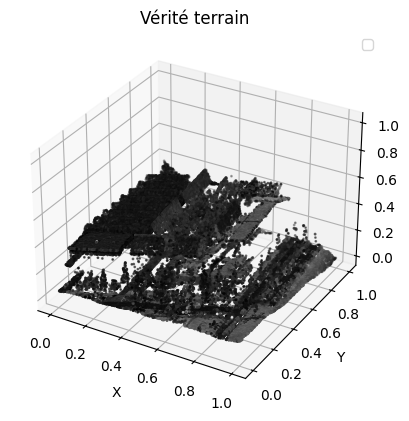

C:\Users\Théo Poujol\AppData\Local\Temp\ipykernel_18636\1734472706.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


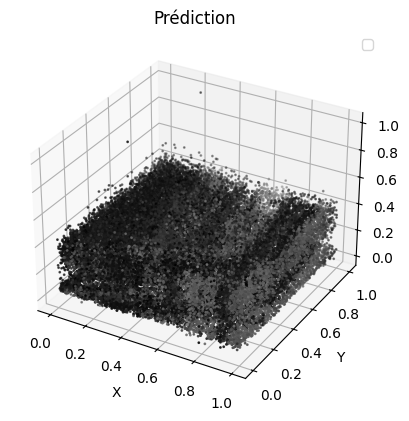

In [18]:
# train(model, loss_fn, coptimizer)
train(model, loss_fn, opt)
pred = test(model, loss_fn, test_loader)

# Concaténer tous les batches
pred = np.concatenate(pred, axis=0)

train_Z = np.array([z for _, z in train_set]).reshape(-1)
val_Z = np.array([z for _, z in val_set]).reshape(-1)
pred_Z = pred.reshape(-1)  # pred déjà concaténé
z_pred_norm = np.concatenate([train_Z, val_Z, pred_Z])

# Figure 1 : Vérité terrain
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(Xsmall_norm, 
            Ysmall_norm, 
            Zsmall_norm, c=(Ismall.astype(np.float64))/np.max(Ismall), marker='o', s=1,cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Vérité terrain')
plt.legend()
plt.show()

# Figure 2 : Prédiction
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(Xsmall_norm, 
            Ysmall_norm, 
            z_pred_norm, c=(Ismall.astype(np.float64))/np.max(Ismall), marker='o', s=1,cmap='gray')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Prédiction')
plt.legend()
plt.show()